# Hackathon Big Data

O primeiro desafio consiste em um cenário de previsão, onde o objetivo será prever o faturamento de cada uma das franquias de uma rede de lojas, onde as franquias estão espalhadas em todo o Brasil.

O segundo desafio consiste em um cenário de expansão, onde o objetivo será prever o faturamento que uma loja teria caso ela existisse em uma região que a franquia ainda não atua.

Este tipo de problema é muito importante para uma rede de franquias existente. A previsão do faturamento é importante para que a franquia possa ter uma estimativa da quantia que ela terá disponível para realizar investimentos e expansão das lojas. A previsão do faturamento em regiões que a loja não atua é importante para que a franquia possa realizar uma expansão mirando as regiões em que ela teria o maior faturamento possível.

# Desafio

**1. Prever o faturamento de lojas existentes na base de dados**

* Neste desafio as equipes deverão prever a média do faturamento mensal dos primeiros três meses de 2018 de cada loja presente na base de dados disponibilizada.

**2. Projetar o faturamento de novas lojas**

* Neste desafio as equipes deverão prever a média do faturamento mensal dos primeiros três meses de 2018 caso a loja existisse em uma região especificada.

O _notebook_ a seguir é estruturado da seguinte forma:

* 1. Imports
* 2. Descrição dos Dados
* 3. Feature Engineering
* 4. Análise de Dados Exploratória
* 5. Preparação dos dados
* 6. Seleção de _Features_
* 7. Modelagem de _Machine Learning_
* 8. Aprimoramento de _Hyperparameters_
* 9. Interpretação dos Resultados

# 1. Coleta de dados

## 1.1. Imports

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import pickle
import requests

## 1.2. Funções Auxiliares

In [104]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 30]
    plt.rcParams['font.size'] = 20
    plt.rcParams["axes.labelsize"] = 30
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    pd.options.display.float_format = '{:,.2f}'.format
    
    sns.set(font_scale = 1.5)

In [105]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 1.3. Carregando dados

São fornecidos 3 arquivos csv, sendo que o objetivo do problema é predizer a coluna "receita" para o dataset de teste.

* **Arquivos**

    * faturamento_lojas_atuais.csv: Faturamento mensal das lojas, contendo informações dos anos de 2016 e 2017

    * lojas_atuais.csv: Não iremos disponibilizar uma descrição das variáveis presentes neste arquivo. Elas representam as características das lojas, como a metragem, número de cadeiras, número de funcionários, etc. Este arquivo também contém  informações da localização da loja. As colunas de localização serão o código do município e código da área de ponderação. Estes códigos são os mesmos utilizados pelo IBGE

    * cenarios_exapansao.csv: Dados cadastrais de lojas para serem utilizadas no desafio 2. Este arquivo contém as mesmas informações contidas no arquivo lojas_atuais.csv
    
* **Features**

    * faturamento_lojas_atuais.csv:
        
        * cod_loja - número de identificação da loja, é único para cada loja
        
        * ano - ano de registro da receita
        
        * mes - mes de registro da receita
        
        * categoria (?) - categoria de produto vendido
        
        * qtde (?) - quantidade de produtos da categoria vendidos
        
        * receita - receita para a respectiva categoria de produtos no mês e ano especificados
        
    * lojas_atuais.csv e cenarios_expansao.csv:
        
        * cod_loja - número de identificação da loja, é único para cada loja
        
        * cod_ap - código de área de ponderação, definido pelo IBGE e restringem pequenas áreas dentro de municípios
        
        * cod_municipio - código do município, definido pelo IBGE
        
        * feature_01 a feature_18 - não explicitadas
        
Será elaborada a _dataframe_ **"df_raw"**, oriunda da junção de **"df_faturamento_raw"** e **"df_lojas_raw"**, carregados dos _datasets_ fornecidos. Por consequência, uma mesma loja possuirá várias linhas, representando o faturamento mês a mes.

In [12]:
df_expansao_raw = pd.read_csv("./data/raw/cenarios_expansao.csv")
df_faturamento_raw = pd.read_csv("./data/raw/faturamento_lojas_atuais.csv")
df_lojas_raw = pd.read_csv("./data/raw/lojas_atuais.csv")

# merge
df_raw = pd.merge(df_lojas_raw, df_faturamento_raw, how = 'left', on = 'cod_loja')
df_raw.head()

,cod_loja,cod_ap,cod_municipio,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,...,feature_14,feature_15,feature_16,feature_17,feature_18,ano,mes,categoria,qtde,receita
0,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,...,NaN,NaN,NaN,NaN,NaN,2016,1,CATEG_01,301.0,9164.86
1,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,...,NaN,NaN,NaN,NaN,NaN,2016,2,CATEG_01,187.0,8175.55
2,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,...,NaN,NaN,NaN,NaN,NaN,2016,3,CATEG_01,242.0,10521.67
3,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,...,NaN,NaN,NaN,NaN,NaN,2016,4,CATEG_01,104.0,4560.91
4,1,4125506005002,4125506,NaN,FEATURE_02_VALUE_04,True,21.76,FEATURE_05_VALUE_04,31,0.168922,...,NaN,NaN,NaN,NaN,NaN,2016,5,CATEG_01,100.0,4263.30


# 2. Descrição dos Dados

Esta seção incluirá os seguintes tópicos:

* Dimensão dos Dados

* Tipo dos Dados

* Verificação de Dados faltantes

* Estatística Descritiva

* Tratamento de Dados faltantes

In [13]:
df1 = df_raw.copy()

In [14]:
df1.columns

Index(['cod_loja', 'cod_ap', 'cod_municipio', 'feature_01', 'feature_02',
       'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07',
       'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12',
       'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
       'feature_18', 'ano', 'mes', 'categoria', 'qtde', 'receita'],
      dtype='object')

## 2.1. Dimensão dos Dados

De forma a entender quão grande o _dataset_ de análise é, será analisada a dimensão do _dataframe_ em questão. Verifica-se que há **1003094** linhas e **26** colunas.

In [15]:
print("Número de linhas: {}".format(df1.shape[0]))
print("Número de colunas: {}".format(df1.shape[1]))

Número de linhas: 1003094
Número de colunas: 26


## 2.2. Tipo dos Dados

Em seguida, serão analisados os tipos de dados existentes no _dataset_, de modo a abordar cada um apropriadamente.

In [18]:
df1.dtypes

cod_loja           int64
cod_ap             int64
cod_municipio      int64
feature_01        object
feature_02        object
feature_03          bool
feature_04       float64
feature_05        object
feature_06         int64
feature_07       float64
feature_08       float64
feature_09       float64
feature_10       float64
feature_11        object
feature_12        object
feature_13       float64
feature_14       float64
feature_15       float64
feature_16       float64
feature_17       float64
feature_18       float64
ano                int64
mes                int64
categoria         object
qtde             float64
receita          float64
dtype: object

## 2.3. Verificação dos Dados Faltantes

É necessário verificar dados faltantes pelo fato de os algoritmos de _Machine Learning_ atuais não reconhecerem dados nulos. Assim, para um melhor desempenho do modelo, é essencial avaliá-los.

In [26]:
df1.isna().sum().sort_values(ascending = False)

feature_11       922631
feature_12       922631
feature_15       714038
feature_18       714038
feature_17       714038
feature_16       714038
feature_14       714038
feature_13       714038
feature_01       635785
feature_04            0
feature_03            0
feature_02            0
receita               0
feature_06            0
cod_municipio         0
cod_ap                0
feature_05            0
feature_10            0
feature_07            0
feature_08            0
feature_09            0
qtde                  0
ano                   0
mes                   0
categoria             0
cod_loja              0
dtype: int64

## 2.4. Tratamento de Dados faltantes

<font color='red'>???????????????????</font>

<font color='red'>???????????????????</font>

<font color='red'>???????????????????</font>

<font color='red'>???????????????????</font>

<font color='red'>???????????????????</font>

## 2.5. Estatística Descritiva

Para realizar uma estatística descritiva, deve-se separar as variáveis númericas das categoricas, pois cada uma possuirá uma forma diferente de análise.

In [42]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64']).drop(['cod_loja', 'cod_ap', 'cod_municipio'], axis = 1)
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

### 2.5.1. Variáveis Numéricas

Para as variáveis numéricas, serão realizadas dois tipos de análise:

* Tendência central
    * Média
    * Mediana
    
* Dispersão
    * Desvio Padrão
    * Mínimo
    * Máximo
    * Intervalo
    * Assimetria
    * Curtose

In [46]:
d1 = num_attributes.describe()
d2 = pd.DataFrame({"intervalo" : num_attributes.apply(lambda x: x.max() - x.min())}).T
d3 = pd.DataFrame({"assimetria" : num_attributes.apply(lambda x: x.skew())}).T
d4 = pd.DataFrame({"curtose" : num_attributes.apply(lambda x: x.kurtosis())}).T

m = pd.concat([d1, d2, d3, d4]).T.reset_index()
m

,index,count,mean,std,min,25%,50%,75%,max,intervalo,assimetria,curtose
0,feature_04,"1,003,094.00",34.39,13.78,3.50,25.66,31.92,41.11,117.36,113.86,1.05,2.60
1,feature_06,"1,003,094.00",5.75,4.95,0.00,3.00,4.00,7.00,63.00,63.00,3.80,24.55
2,feature_07,"1,003,094.00",0.17,0.05,0.06,0.14,0.18,0.20,0.41,0.35,0.50,0.97
3,feature_08,"1,003,094.00",0.17,0.05,0.04,0.13,0.17,0.19,0.39,0.35,0.33,0.70
4,feature_09,"1,003,094.00",602.74,"1,383.63",1.44,11.82,56.55,334.70,"5,593.91","5,592.47",2.95,7.56
5,feature_10,"1,003,094.00",3.92,2.64,0.42,2.40,3.16,4.46,31.80,31.38,3.29,19.35
6,feature_13,"289,056.00",94.82,8.58,44.10,92.20,100.00,100.00,100.00,55.90,-2.15,5.11
7,feature_14,"289,056.00",83.71,13.49,0.00,79.70,86.90,91.90,100.00,100.00,-3.27,16.43
8,feature_15,"289,056.00",82.51,34.54,0.00,100.00,100.00,100.00,100.00,100.00,-1.74,1.34
9,feature_16,"289,056.00",96.23,12.95,50.00,100.00,100.00,100.00,100.00,50.00,-3.23,8.55


Observando os dados estatísticos de "receita", tem-se:

* Média = 9334,46; indica a média mensal de receita de todas lojas e todas categorias de produto
* Desvio Padrão (std) = 23670,26; este valor de desvio padrão diz que há valores negativos de receita, considerando a média acima, o que não faz sentido. Em análises bivariadas este parâmetro será mais explorado
* Mínimo (min) = 0; indica que, em determinado mês, alguma categoria de produto não vendeu nenhuma unidade 
* Máximo (max) = 975106,4
* Assimetria = 7,5; indica que os valores de receita possuem uma "cauda" mais longa do lado direito da ordenada, ou, em outras palavras, que os dados estão concentrados mais a esquerda quando comparados com uma distribuição normal
* Curtose = 94,52; indica o "achatamento" da curva, ou seja, a curva de receita é concentrada predominantemente em uma região

### 2.5.2. Atributos categóricos

Para a análise de atributos categóricos, são utilizados _boxplots_, de modo a analisar visualmente a dispersão, posição, simetria e outliers do _dataset_.

<font color='red'>???????????????????</font>

COLOCAR ANALISE DOS GRAFICOS

<font color='red'>???????????????????</font>

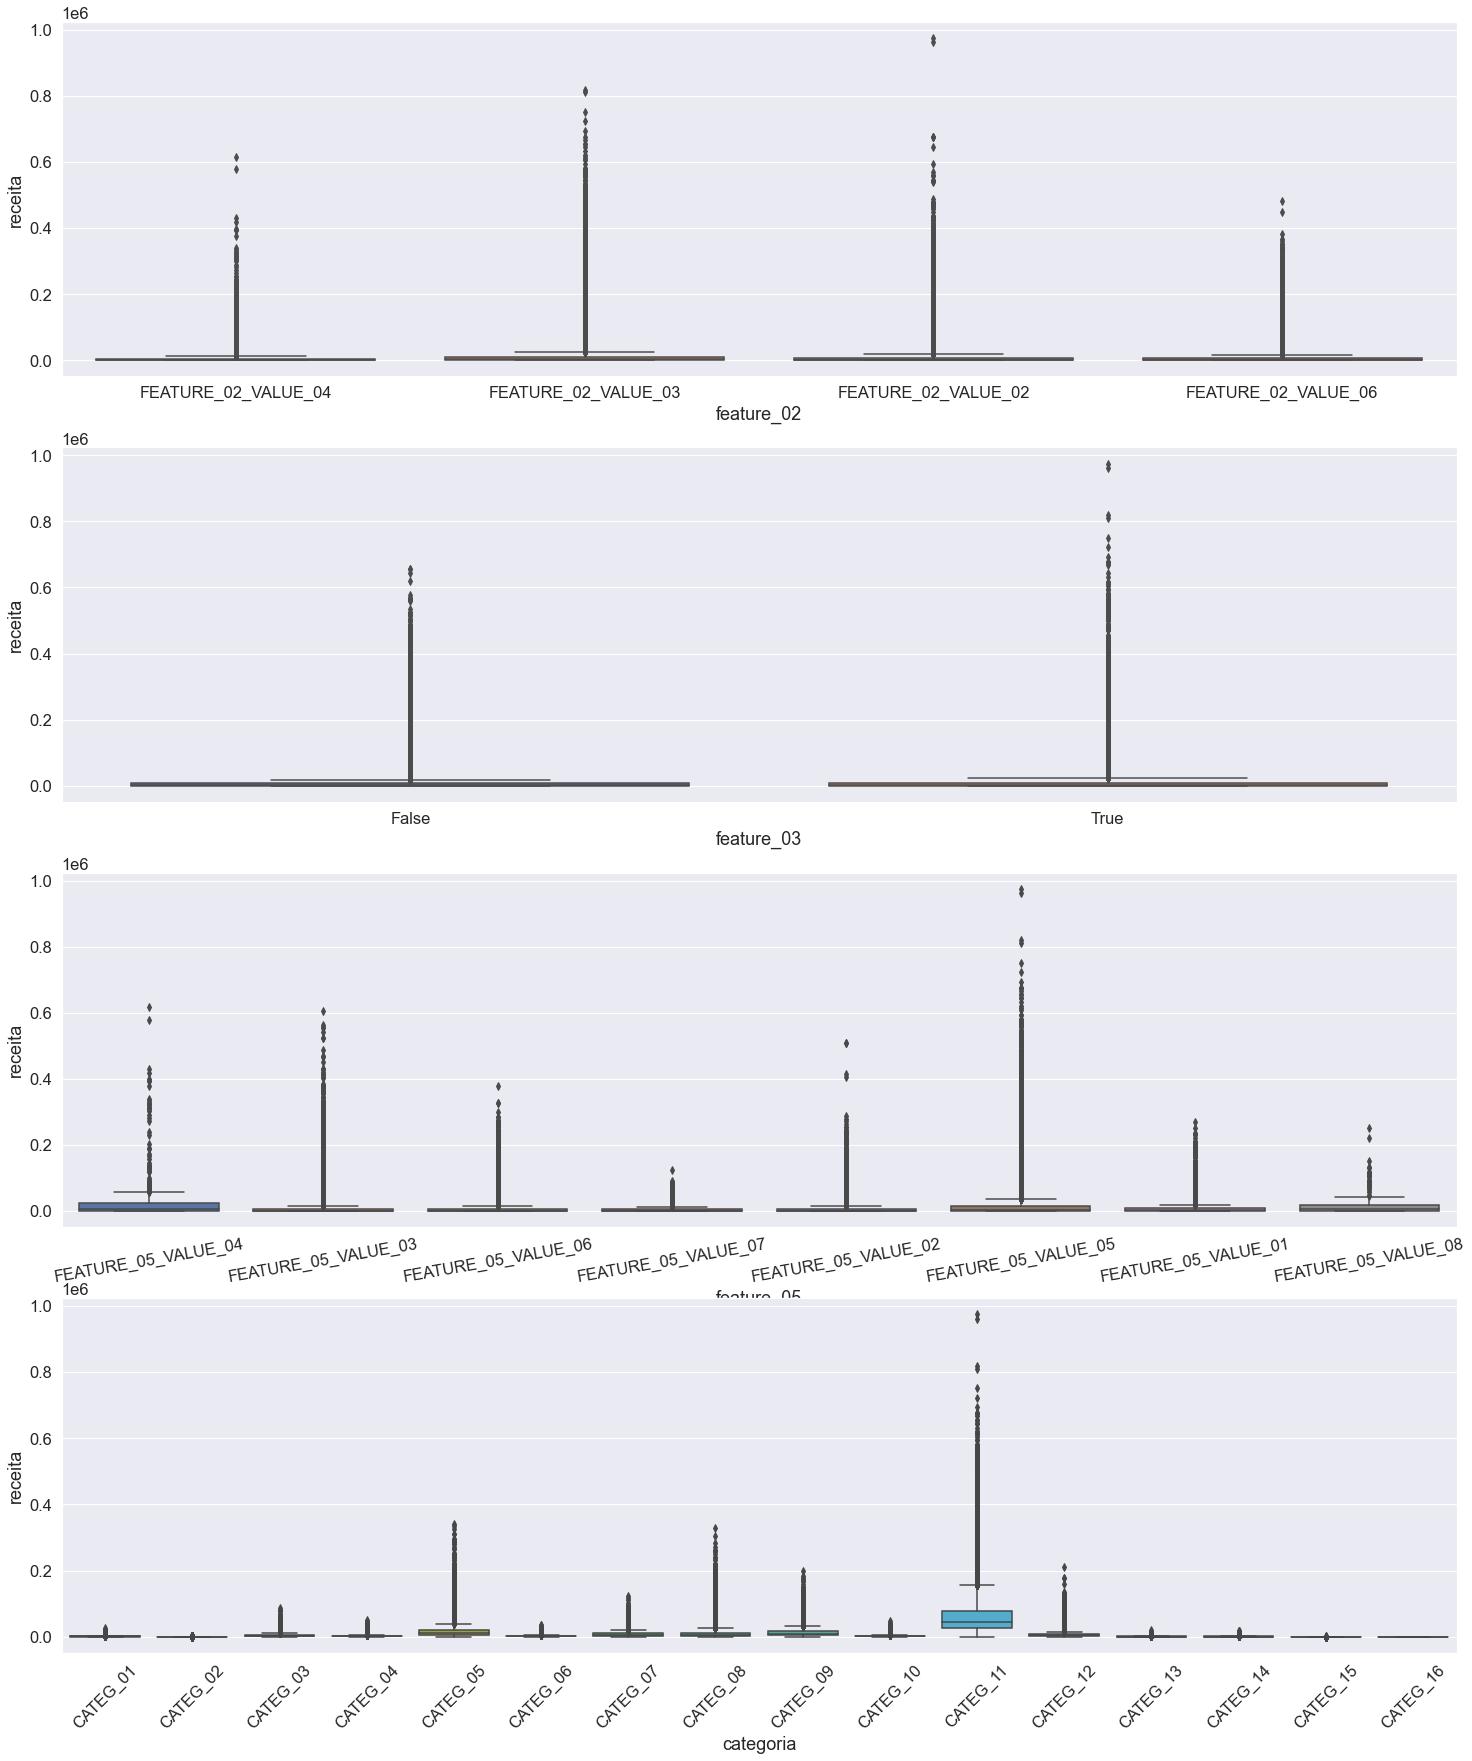

In [108]:
plt.subplot(4,1,1)
_ = sns.boxplot(x = 'feature_02', y = 'receita', data = df1)

plt.subplot(4,1,2)
_ = sns.boxplot(x = 'feature_03', y = 'receita', data = df1)

plt.subplot(4,1,3)
_ = sns.boxplot(x = 'feature_05', y = 'receita', data = df1)
_ = plt.xticks(rotation = 10)

plt.subplot(4,1,4)
_ = sns.boxplot(x = 'categoria', y = 'receita', data = df1)
_ = plt.xticks(rotation = 45)

In [57]:
cat_attributes.isna().sum()

feature_01    635785
feature_02         0
feature_03         0
feature_05         0
feature_11    922631
feature_12    922631
categoria          0
dtype: int64